# Protein Structure Visualisation

## Overview
This notebook provides interactive 3D visualisation and analysis of protein structures from the CATH database. The tool enables exploration of protein folds, domains, and structural classifications through interactive molecular visualisations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import requests
import pandas as pd
from IPython.display import display, clear_output
import warnings

In [2]:
def parse_cath_file(file_path="cath-chain-list.txt"):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('#') or not line.strip():
                continue
            parts = line.split()
            if len(parts) >= 12:
                cath_id = parts[0]
                pdb_id = cath_id[:4]  
                chain_id = cath_id[4]  
                data.append({
                    'cath_id': cath_id,
                    'pdb_id': pdb_id,
                    'chain_id': chain_id,
                    'residue_count': int(parts[10]),
                    'resolution': float(parts[11])
                })
    return pd.DataFrame(data)

In [3]:
df = parse_cath_file("cath-chain-list.txt")
print(f"Loaded {len(df)} proteins")
print("\nFirst 10 proteins:")
print(df.head(10))

Loaded 199998 proteins

First 10 proteins:
   cath_id pdb_id chain_id  residue_count  resolution
0  101mA00   101m        A            154        2.07
1  102lA00   102l        A            163        1.74
2  102mA00   102m        A            154        1.84
3  103lA00   103l        A            159        1.90
4  103mA00   103m        A            154        2.07
5  104lA00   104l        A            164        2.80
6  104lB00   104l        B            164        2.80
7  104mA00   104m        A            153        1.71
8  105mA00   105m        A            153        2.02
9  106mA00   106m        A            154        1.99


In [4]:
def get_ca_coordinates(pdb_id, chain_id='A'):
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    
    try:
        response = requests.get(url, timeout=10)
        if response.status_code != 200:
            print(f"Failed to download {pdb_id}")
            return None
        
        ca_coords = []
        residue_numbers = []
        
        for line in response.text.split('\n'):
            if line.startswith('ATOM'):
                atom_name = line[12:16].strip()
                chain = line[21:22].strip()
                
                if atom_name == 'CA' and (chain == chain_id or (chain == '' and chain_id == '0')):
                    try:
                        x = float(line[30:38])
                        y = float(line[38:46])
                        z = float(line[46:54])
                        res_num = int(line[22:26])
                        ca_coords.append([x, y, z])
                        residue_numbers.append(res_num)
                    except:
                        continue
        
        if ca_coords:
            return np.array(ca_coords), residue_numbers
        return None
        
    except Exception as e: 
        print(f"Error processing {pdb_id}: {e}")
        return None

In [5]:
def visualise_protein(pdb_id, chain_id='A', figsize=(15, 5)):
    
    result = get_ca_coordinates(pdb_id, chain_id) 
    coords, res_numbers = result
    
    #create figure with 3 subplots
    fig = plt.figure(figsize=figsize)
    
    # 1. 3D structure
    ax1 = fig.add_subplot(131, projection='3d')
    
    # plot backbone
    ax1.plot(coords[:, 0], coords[:, 1], coords[:, 2], 
             'b-', linewidth=1.5, alpha=0.6)
    
    #color points by position
    colors = np.arange(len(coords))
    scatter = ax1.scatter(coords[:, 0], coords[:, 1], coords[:, 2], 
                         c=colors, cmap='rainbow', s=20, alpha=0.8)
    
    ax1.set_xlabel('X (Å)', fontsize=10)
    ax1.set_ylabel('Y (Å)', fontsize=10)
    ax1.set_zlabel('Z (Å)', fontsize=10)
    ax1.set_title(f'{pdb_id}-{chain_id} 3D Structure\n{len(coords)} residues', fontsize=12)
    
    # 2. distance matrix
    ax2 = fig.add_subplot(132)
    
    # calculate pairwise distances
    dist_matrix = np.zeros((len(coords), len(coords)))
    for i in range(len(coords)):
        for j in range(len(coords)):
            dist_matrix[i, j] = np.linalg.norm(coords[i] - coords[j])
    
    im = ax2.imshow(dist_matrix, cmap='viridis', aspect='auto')
    ax2.set_xlabel('Residue index', fontsize=10)
    ax2.set_ylabel('Residue index', fontsize=10)
    ax2.set_title('Distance Matrix (Å)', fontsize=12)
    plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
    
    # 3. projections
    ax3 = fig.add_subplot(133)
    
    # XY projection with color gradient
    scatter2 = ax3.scatter(coords[:, 0], coords[:, 1], 
                          c=colors, cmap='rainbow', s=15, alpha=0.7)
    ax3.plot(coords[:, 0], coords[:, 1], 'gray', linewidth=0.5, alpha=0.3)
    
    ax3.set_xlabel('X (Å)', fontsize=10)
    ax3.set_ylabel('Y (Å)', fontsize=10)
    ax3.set_title('XY Projection', fontsize=12)
    ax3.set_aspect('equal')
    plt.colorbar(scatter2, ax=ax3, fraction=0.046, pad=0.04, label='Residue index')
    
    plt.suptitle(f'Protein Structure Analysis: {pdb_id} Chain {chain_id}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return coords, dist_matrix


Enter the protein index to visualise: (0-199997): 200

Protein name: 1a0aB00
PDB: 1a0a, Chain: B
Resolution: 2.8 Å
Expected residues: 63


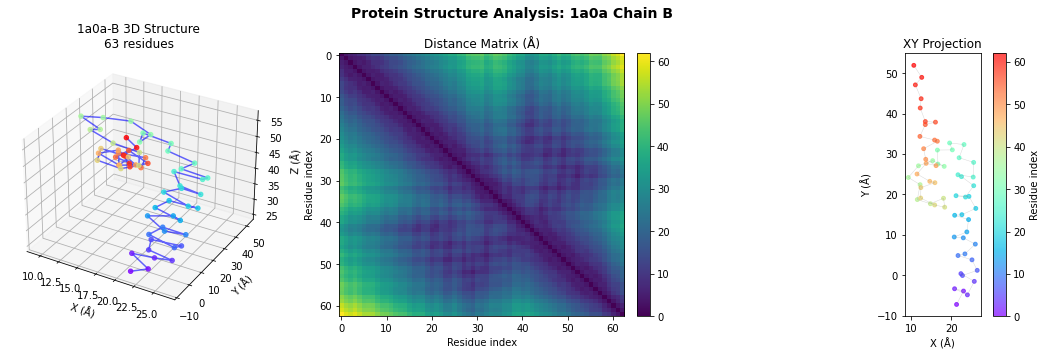

In [7]:
#user inputs protein ID
protein_input = input(f"\nEnter protein ID (e.g., 159l-A): ").strip()
if protein_input.endswith('.npz'):
    protein_input = protein_input[:-4]
pdb_id, chain_id = protein_input.split('-')

#find protein in dataframe
protein = df[(df['pdb_id'] == pdb_id.lower()) & (df['chain_id'] == chain_id.upper())].iloc[0]

print(f"\nProtein name: {protein['cath_id']}")
print(f"PDB: {protein['pdb_id']}, Chain: {protein['chain_id']}")
print(f"Resolution: {protein['resolution']} Å")
print(f"Expected residues: {protein['residue_count']}")
coords, dist_matrix = visualise_protein(protein['pdb_id'], protein['chain_id'])